In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
import cftime
import dask
import os
import cf_xarray
from scipy import stats
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
# from cartopy.util import add_cyclic_point
import cartopy.mpl.ticker as cticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.ticker as ticker
import glob
from os.path import join
import warnings
warnings.filterwarnings("ignore")

In [2]:
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point
from mpl_toolkits.axes_grid1 import make_axes_locatable
import nc_time_axis
import cftime

### PPE TWS Analysis 

### Load Dataset

In [3]:
################# Augmentate PPE CLM Data 
def y_input(clm_ppe_path, start_year=1901, end_year=2000):

    """ This function depends on a file path to intermediate processed files of CLM output (by year) that each contain
    variable information for all 500 ensemble members. See 'intermediate_data_gen.ipynb' notebook for how
    to generate that data.

    For the output data, this funciton loads all of the data available, subsets, and stacks the CLM data into a 
    Machine learning ingestible format. 
    
    For the input data, it load the parameters of the CLM ensemble and duplicates it to match the size of the stacked
    output data. Additioinally, it adds transformed date features (cos and sin transformations of month, and year) to 
    make each sample unique. 
    """
    
    conus_min_lon = 235
    conus_max_lon = 294

    file_path = "/bsuhome/ksilwimba/scratch/NCAR/Data/output_v4/PPEn11_transient_LHC0000.clm2.h0.2005-02-01-00000.nc"
    file = xr.open_dataset(file_path)

    grid_cells = file.gridcell.values
    longitudes = file.grid1d_lon.values
    grid_lon_df = pd.DataFrame({'GridCell': grid_cells, 'Longitude': longitudes})
    conus_grid_cells = grid_lon_df[(grid_lon_df['Longitude'] >= conus_min_lon) & (grid_lon_df['Longitude'] <= conus_max_lon)]
    
    #----------- load ppe data 
    clm_ppe_files = sorted(glob.glob(join(clm_ppe_path, "*.nc")))
    clm_ppe_data = xr.open_mfdataset(clm_ppe_files, parallel=True).sel(time=slice(f"{start_year}", f"{end_year}")).sel(gridcell=list(conus_grid_cells.GridCell))
    clm_ppe_data_full = xr.open_mfdataset(clm_ppe_files, parallel=True).sel(time=slice(f"{start_year}", f"{end_year}"))
    #----------- stack 
    clm_ppe_data =  clm_ppe_data.stack({'sample': ('member', 'time')})
    clm_ppe_data_full =  clm_ppe_data_full.stack({'sample': ('member', 'time')})
    
    return clm_ppe_data, clm_ppe_data_full

In [4]:
#---------- Compute CLM PPE monthly data
clm_ppe_path ="/bsuhome/ksilwimba/scratch/NCAR/Data/LAI/TLAI"

#---------- Training data from 1901 to 2000
monthly_data_tr, clm_ppe_data_full_tr = y_input(clm_ppe_path, start_year=1901, end_year=2000)

#---------- Validation data from 2000 to 2014
monthly_data_va, clm_ppe_data_full_va = y_input(clm_ppe_path, start_year=2000, end_year=2014)


In [5]:
############ Global mean
def global_mean(data: xr.DataArray, land_area: xr.DataArray, cf: float = 1.0) -> xr.DataArray:
    """
    Compute the global mean of data weighted by land area.

    Parameters:
    - data: xr.DataArray
        The input data array for which the global mean needs to be computed.
        Must have a 'gridcell' dimension.
    - land_area: xr.DataArray
        Land area weights for each gridcell. Must have the same 'gridcell' dimension as data.
    - cf: float, optional (default=1.0)
        A scaling factor to apply to the global mean.

    Returns:
    - xr.DataArray
        The global mean of the data, weighted by land area.
        Ensure the data and land area are aligned along the 'gridcell' dimension
    """
    
    #----------- Apply the land area weighting
    weighted_data = land_area.sel(gridcell=list(conus_grid_cells.GridCell))*data
    # weighted_data_full = land_area*data
    
    #----------- Compute the global mean, sum over the 'gridcell' dimension
    global_mean_value = cf*(weighted_data.sum(dim='gridcell')/land_area.sum(dim='gridcell')).compute()
    # global_mean_value_full = cf*(weighted_data_full.sum(dim='gridcell')/land_area.sum(dim='gridcell')).compute()

    return global_mean_value

In [6]:
conus_min_lon = 235
conus_max_lon = 294

file_path = "/bsuhome/ksilwimba/scratch/NCAR/Data/output_v4/PPEn11_transient_LHC0000.clm2.h0.2005-02-01-00000.nc"
file = xr.open_dataset(file_path)

grid_cells = file.gridcell.values
longitudes = file.grid1d_lon.values
grid_lon_df = pd.DataFrame({'GridCell': grid_cells, 'Longitude': longitudes})

conus_grid_cells = grid_lon_df[(grid_lon_df['Longitude'] >= conus_min_lon) & (grid_lon_df['Longitude'] <= conus_max_lon)]

In [7]:
#----------- Area weight 
land_area = xr.open_dataset('/bsuhome/ksilwimba/scratch/NCAR/Data/helpers/sparsegrid_landarea.nc').landarea

#----------- Train Y global mean 
tws_tr_gmean = global_mean(monthly_data_tr, land_area)#.TWS.values.reshape(-1,1)
tws_va_gmean= global_mean(monthly_data_va, land_area)#.TWS.values.reshape(-1,1)

In [8]:
clm_ppe_tr = pd.DataFrame({"member":tws_tr_gmean.member, "time":tws_tr_gmean.time,"ppe_clm_model_tr":tws_tr_gmean.TLAI.values})
clm_ppe_va = pd.DataFrame({"member":tws_va_gmean.member, "time":tws_va_gmean.time,"ppe_clm_model_va":tws_va_gmean.TLAI.values})

def convert_cftime_to_datetime64(cf_time):
    return np.datetime64(f"{cf_time.year}-{cf_time.month:02d}-{cf_time.day:02d}")
clm_ppe_tr['time'] = clm_ppe_tr['time'].apply(convert_cftime_to_datetime64)
clm_ppe_tr["month"] = clm_ppe_tr.time.dt.month


clm_ppe_va['time'] = clm_ppe_va['time'].apply(convert_cftime_to_datetime64)
clm_ppe_va["month"] = clm_ppe_va.time.dt.month

In [9]:
clm_ppe_tr

,member,time,ppe_clm_model_tr,month
0,1,1901-01-01,0.421182,1
1,1,1901-02-01,0.391966,2
2,1,1901-03-01,0.375999,3
3,1,1901-04-01,0.364665,4
4,1,1901-05-01,0.364892,5
...,...,...,...,...
599995,500,2000-08-01,0.499153,8
599996,500,2000-09-01,0.503840,9
599997,500,2000-10-01,0.467132,10
599998,500,2000-11-01,0.432404,11


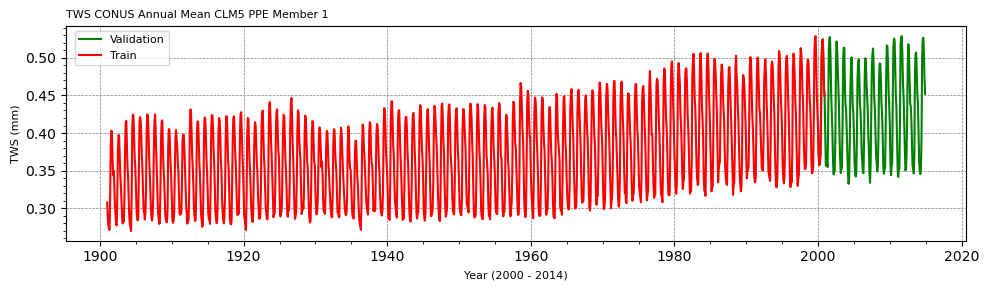

In [33]:
# ---------- Create a figure and a single axes object for plotting
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))

# ---------- Loop over the desired member (in this case, member 2)
for i in range(2, 3):
    # ---------- Plot the validation data for the current member (green line)
    line, = ax.plot(
        clm_ppe_va[clm_ppe_va['member'] == i]['time'].values,
        clm_ppe_va[clm_ppe_va['member'] == i]['ppe_clm_model_va'].values,
        label="Validation", linewidth=1.5, color="g"
    )
    # ---------- Plot the training data for the current member (red line)
    ax.plot(
        clm_ppe_tr[clm_ppe_tr['member'] == i]['time'].values,
        clm_ppe_tr[clm_ppe_tr['member'] == i]['ppe_clm_model_tr'].values,
        label="Train", linewidth=1.5, color="r"
    )

# ---------- Set the plot title (using the provided title) and axis labels
ax.set_title('TWS CONUS Annual Mean CLM5 PPE Member 1', fontsize=8, fontweight='regular', loc="left")
ax.set_ylabel('TWS (mm)', fontsize=8)
ax.set_xlabel('Year (2000 - 2014)', fontsize=8)

# ---------- Enable minor ticks and gridlines for readability
ax.minorticks_on()
ax.grid(linestyle='--', linewidth=0.5, color='grey')

# ---------- Add a legend to the figure (positioned in the upper right)
fig.legend(loc='upper right', fontsize=8, bbox_to_anchor=(0.18, 0.9))

# ---------- Adjust layout and display the plot
plt.tight_layout()
# plt.savefig("./Figures/Train_Valid.pdf", bbox_inches='tight')
plt.show()


In [12]:
def regrid_to_lat_lon(data_array):
    """
    Regrids a given data array from a sparse grid to a standard latitude/longitude grid.
    
    It is recommended to perform any dimension-reducing calculations before calling this function to improve performance.
    
    Args:
    data_array (xarray.DataArray): The data array to regrid.
    
    Returns:
    xarray.DataArray: The data array regridded to standard latitude/longitude.
    """

    #---------------- Load the sparse grid information
    base_directory = '/bsuhome/ksilwimba/scratch/NCAR/Data/output_v4/'
    filename = 'clusters.clm51_PPEn02ctsm51d021_2deg_GSWP3V1_leafbiomassesai_PPE3_hist.annual+sd.400.nc'
    sparse_grid = xr.open_dataset(f'{base_directory}{filename}')
    
    #---------------- Determine the shape and coordinates for the output map
    output_shape = []
    coordinates = []
    
    #---------------- Include dimensions other than "gridcell" from the input data array
    for coord, size in zip(data_array.coords, data_array.shape):
        if size != 400:  # Assuming 400 is the gridcell count for the sparse grid
            output_shape.append(size)
            coordinates.append((coord, data_array[coord].values))
            
    #---------------- Include latitude and longitude from the sparse grid
    for coord in ['lat', 'lon']:
        size = len(sparse_grid[coord])
        output_shape.append(size)
        coordinates.append((coord, sparse_grid[coord].values))

    #---------------- Initialize the output array with NaNs
    output_array = np.full(output_shape, np.nan)
    
    #---------------- Fill the array with values from the input data array
    ds = xr.open_dataset('/bsuhome/ksilwimba/scratch/NCAR/Data/output_v4/PPEn11_transient_LHC0000.clm2.h0.2005-02-01-00000.nc')
    for i in range(400):  # Iterate over grid cells
        lat = ds.grid1d_lat[i]
        lon = ds.grid1d_lon[i]
        cluster_center = sparse_grid.rcent.sel(lat=lat, lon=lon, method='nearest')
        mask = sparse_grid.cclass == cluster_center
        
        if output_array.ndim == 2:
            output_array[mask] = data_array.isel(gridcell=i)
        else:
            num_matches = mask.sum().values
            output_array[:, mask] = np.tile(data_array.isel(gridcell=i).values[:, np.newaxis], [1, num_matches])
    
    #---------------- Create and return the output DataArray
    output_data_array = xr.DataArray(data=output_array, name=data_array.name, coords=coordinates)
    output_data_array.attrs = data_array.attrs

    return output_data_array

In [13]:
#---------- Training data from 1901 to 2000
monthly_data, clm_ppe_data_full = y_input(clm_ppe_path, start_year=2000, end_year=2014)

In [14]:
clm_ppe_data_full.TLAI

<xarray.DataArray 'TLAI' (gridcell: 400, sample: 90000)>
dask.array<reshape, shape=(400, 90000), dtype=float32, chunksize=(400, 6840), chunktype=numpy.ndarray>
Coordinates:
  * sample   (sample) object MultiIndex
  * member   (sample) int64 1 1 1 1 1 1 1 1 ... 500 500 500 500 500 500 500 500
  * time     (sample) object 2000-01-01 00:00:00 ... 2014-12-01 00:00:00
Dimensions without coordinates: gridcell
Attributes:
    long_name:     total projected leaf area index
    units:         m^2/m^2
    cell_methods:  time: mean

In [15]:
#------------------- Select CONUS region
us_lat_bounds = (24.031414,49.47644)
us_lon_bounds = (233.75,293.75)
#---------- Regrid the sparse DataArray to standard latitude/longitude grid
tws_gmean_full_conus = regrid_to_lat_lon(clm_ppe_data_full.TLAI).sel(lat=slice(*us_lat_bounds),\
                                                                     lon=slice(*us_lon_bounds))

In [17]:
tws_data = clm_ppe_data_full.TLAI.unstack().mean(dim="time").T
tws_data 

<xarray.DataArray 'TLAI' (member: 500, gridcell: 400)>
dask.array<transpose, shape=(500, 400), dtype=float32, chunksize=(38, 400), chunktype=numpy.ndarray>
Coordinates:
  * member   (member) int64 1 2 3 4 5 6 7 8 ... 493 494 495 496 497 498 499 500
Dimensions without coordinates: gridcell

In [18]:
tws_gmean_full_conus = regrid_to_lat_lon(tws_data).sel(lat=slice(*us_lat_bounds),\
                                                                     lon=slice(*us_lon_bounds))

In [20]:
scaler = StandardScaler()

tws_tr_scaled = scaler.fit_transform(clm_ppe_data_full.TLAI.T.values)

In [21]:
lat = tws_gmean_full_conus.lat
lon = tws_gmean_full_conus.lon

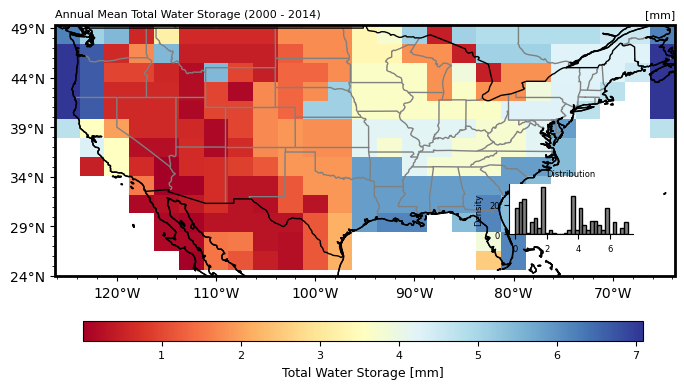

In [32]:

# ---------- Define the function to create a filled pcolormesh plot with an inset histogram
def _make_plot_without_contours_(data_nc: xr.DataArray, ax: plt.Axes, title: str) -> object:
    """
    Creates a filled pcolormesh plot from the input data array with cyclic continuity added to longitude,
    and overlays an inset histogram showing the data distribution.

    Parameters:
        data_nc (xr.DataArray): Input data array with 'lat' and 'lon' coordinates.
        ax (plt.Axes): Matplotlib axes (with Cartopy PlateCarree projection) to plot on.
        title (str): Title for the subplot (displayed on the left).

    Returns:
        mesh (matplotlib.collections.QuadMesh): The QuadMesh object created by pcolormesh.
    """
    # ---------- Add cyclic point to data and update longitude coordinates
    data, lons = add_cyclic_point(data_nc, coord=data_nc['lon'])
    lats = data_nc['lat']
    lons2d, lats2d = np.meshgrid(lons, lats)
    
    # ---------- Create a filled pcolormesh plot using the provided colormap and shading
    mesh = ax.pcolormesh(
        lons2d, lats2d, data, transform=ccrs.PlateCarree(),
        cmap='RdYlBu', shading='auto'
    )
    
    # ---------- Set subplot titles: right title shows units, left title shows the provided title
    ax.set_title("[mm]", loc='right', fontweight='regular', fontsize=8)
    ax.set_title(title, fontweight='regular', fontsize=8, loc='left')
    
    # ---------- Configure x-axis ticks and formatting for longitudes
    ax.set_xticks(np.arange(-120, -60, 10), crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    
    # ---------- Configure y-axis ticks and formatting for latitudes
    ax.set_yticks(np.arange(24, 50, 5), crs=ccrs.PlateCarree())
    lat_formatter = cticker.LatitudeFormatter()
    ax.yaxis.set_major_formatter(lat_formatter)
        
    # ---------- Add geographic features: state boundaries and country borders
    states = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m', facecolor='none'
    )
    ax.add_feature(states, edgecolor='gray')
    ax.add_feature(cfeature.BORDERS, linestyle='-')
    
    # ---------- Enable minor ticks, add coastlines and coastline features for context
    ax.minorticks_on()
    ax.coastlines()
    ax.add_feature(cfeature.COASTLINE)
    
    # ---------- Create an inset axes in the lower right corner for the data distribution histogram
    inset_ax = inset_axes(ax, width="20%", height="20%", loc='lower right', borderpad=3)
    
    # ---------- Flatten the data array and filter out NaN values for the histogram
    data_flat = data.flatten()
    data_flat = data_flat[~np.isnan(data_flat)]
    inset_ax.hist(data_flat, bins=30, color='gray', edgecolor='black')
    inset_ax.set_title('Distribution', fontsize=6)
    inset_ax.tick_params(axis='both', which='major', labelsize=6)
    inset_ax.set_ylabel('Density', fontsize=6)
    
    # ---------- Remove top and right spines in the inset for a cleaner appearance
    inset_ax.spines['top'].set_visible(False)
    inset_ax.spines['right'].set_visible(False)
    
    return mesh

# ---------- Create the figure and axes for the spatial map
fig, ax = plt.subplots(
    nrows=1, ncols=1, figsize=[8, 5],
    subplot_kw={'projection': ccrs.PlateCarree()},
    gridspec_kw={'wspace': 0.017, 'hspace': -0.2}
)

# ---------- Set the border color and width for the geo frame
ax.spines['geo'].set_edgecolor('black')
ax.spines['geo'].set_linewidth(2)

# ---------- Create the spatial map using the _make_plot_without_contours_ function
mesh = _make_plot_without_contours_(
    tws_gmean_full_conus[0], ax,
    'Annual Mean Total Water Storage (2000 - 2014)'
)

# ---------- Adjust layout for the colorbar and create a horizontal colorbar
fig.subplots_adjust(bottom=0.2, top=0.9)
cbar_ax = fig.add_axes([0.16, 0.17, 0.7, 0.04])
cbar = fig.colorbar(mesh, cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=8)
cbar.set_label('Total Water Storage [mm]', fontweight='regular', fontsize=9) 
# plt.savefig("./Figures/conus_Map.pdf", dpi=600, bbox_inches='tight')
plt.show()


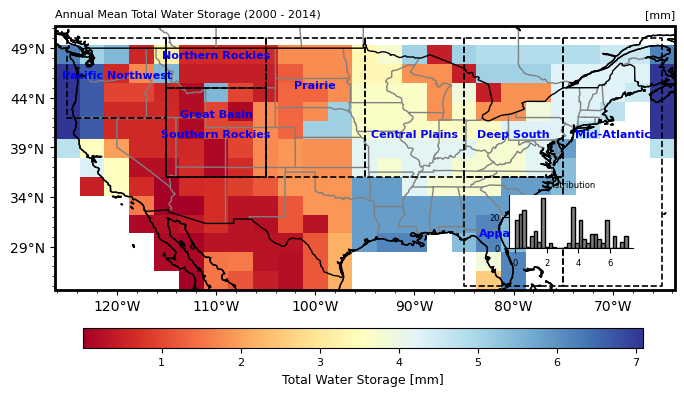

In [31]:
# ---------- Define a function to add CONUS regions and labels
def _add_conus_regions(ax: plt.Axes) -> None:
    """
    Adds approximate CONUS regional boundaries and labels on a Cartopy map.
    
    Parameters:
        ax (plt.Axes): A Matplotlib axis object with a Cartopy projection.
    """
    # ---------- Define regions with approximate boundaries and label positions
    regions = {
        "Pacific Northwest": {"coords": [[-125, 50], [-125, 42], [-115, 42], [-115, 50]], "label": (-120, 46)},
        "Great Basin": {"coords": [[-115, 50], [-115, 36], [-105, 36], [-105, 50]], "label": (-110, 42)},
        "Northern Rockies": {"coords": [[-115, 50], [-115, 45], [-105, 45], [-105, 50]], "label": (-110, 48)},
        "Southern Rockies": {"coords": [[-115, 45], [-115, 36], [-105, 36], [-105, 45]], "label": (-110, 40)},
        "Prairie": {"coords": [[-105, 50], [-105, 36], [-95, 36], [-95, 50]], "label": (-100, 45)},
        "Central Plains": {"coords": [[-95, 50], [-95, 36], [-85, 36], [-85, 50]], "label": (-90, 40)},
        "Deep South": {"coords": [[-85, 50], [-85, 36], [-75, 36], [-75, 50]], "label": (-80, 40)},
        "Appalachia": {"coords": [[-85, 36], [-85, 25], [-75, 25], [-75, 36]], "label": (-80, 30)},
        "Mid-Atlantic": {"coords": [[-75, 50], [-75, 25], [-65, 25], [-65, 50]], "label": (-70, 40)},
    }
    
    # ---------- Loop through each region and add its boundary and label
    for region, info in regions.items():
        coords = info["coords"]
        coords.append(coords[0])  # Close the polygon
        lons, lats = zip(*coords)
        
        # ---------- Plot region boundary
        ax.plot(lons, lats, transform=ccrs.PlateCarree(), color='black', linewidth=1.2, linestyle='--')
        
        # ---------- Add region label
        label_lon, label_lat = info["label"]
        ax.text(label_lon, label_lat, region, transform=ccrs.PlateCarree(),
                fontsize=8, fontweight='bold', ha='center', color='blue')

# ---------- Integrate the region labels into an existing spatial map
# Create a single subplot with a Cartopy PlateCarree projection.
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[8, 5],
                       subplot_kw={'projection': ccrs.PlateCarree()},
                       gridspec_kw={'wspace': 0.017, 'hspace': -0.2})

# ---------- Set the border color and width for the subplot.
ax.spines['geo'].set_edgecolor('black')
ax.spines['geo'].set_linewidth(2)

# ---------- Create the spatial map using the _make_plot_without_contours_ helper function.
# Note: Ensure that `tws_gmean_full_conus` and `_make_plot_without_contours_` are defined.
mesh = _make_plot_without_contours_(
    tws_gmean_full_conus[0], ax,
    'Annual Mean Total Water Storage (2000 - 2014)'
)

# ---------- Add CONUS regions and labels to the map.
_add_conus_regions(ax)

# ---------- Create a horizontal colorbar for the plot.
fig.subplots_adjust(bottom=0.2, top=0.9)
cbar_ax = fig.add_axes([0.16, 0.17, 0.7, 0.04])
cbar = fig.colorbar(mesh, cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=8)
cbar.set_label('Total Water Storage [mm]', fontweight='regular', fontsize=9)
# plt.savefig("./Figures/conus_Map_with_regions.pdf", dpi=600, bbox_inches='tight')
plt.show()
